### Environment Setup

In [1]:
# Import Usual usage modules.
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# For images (Navigating, writing, and loading)
import os
from IPython.display import display
from PIL import Image

# Import module to move files around
import csv

# Import TensorFlow and Keras for GPU Usage (DESKTOP GPU / LAPTOP CPU)
import tensorflow as tf
import keras

# Import the Keras libraries and packages for usage
from keras.models import Sequential, Model, load_model
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Convolution2D, Activation, BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Dropout, Lambda, merge
from keras.regularizers import l1, l2
from keras import optimizers
from keras.callbacks import History, EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# Import keras package for data augmentation
from keras.preprocessing.image import ImageDataGenerator
 
# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Check that the GPU is being utilized
print(tf.__version__)
print(keras.__version__)

2.1.0
2.3.1


Using TensorFlow backend.


### Preprocessing

I want to split up the image data I have so that they are organized by class, and eye (Left or Right)
    - Level 0 (Retinopathy Absent)
    - Level 1 (Mild Retinopathy)
    - Level 2 (Moderate Retinopathy)
    - Level 3 (Severe Retinopathy)
    - Level 4 (Proliferative Retinopathy)

In [ ]:
# Set the directories
SOURCE_ROOT = 'E:\Portfolio Projects\Python - CNN\All Images\\'
DEST_ROOT = 'E:\Portfolio Projects\Python - CNN\Training\\'

with open('DR_Labels_Cropped.csv') as infile:
    # Skip the header row
    next(infile)  
    reader = csv.reader(infile)
    seen = set()
    for image, level in reader:
        # Create a new directory if needed
        if level not in seen:
            os.mkdir(os.path.join(DEST_ROOT, level))
            seen.add(level)

        src = os.path.join(SOURCE_ROOT, image + '.jpeg')
        dest = os.path.join(DEST_ROOT, level, image + '.jpeg')

        try:
            os.rename(src, dest)
        except WindowsError as e:
            print(e)

Now we have the images all in separate class folders under the Training folder.

I will use a validation split in the image generator when I augment to make the validation subset.

In [2]:
# Import the labels
df = pd.read_csv("DR_Labels_Cropped.csv")

I have to account for class balance...
- There is an imbalance here
- Due to the ratio, however, at the worst case is 40:1
- It shouldn't be a problem with the size of the dataset itself
- I could set separate weights in the model to make up for this if needed.

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64


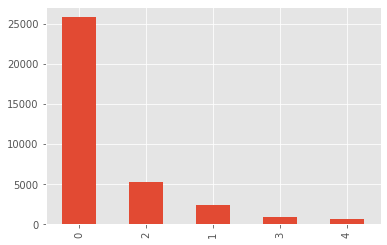

In [3]:
# Count and plot the sum of each level
df['level'].value_counts().plot(kind='bar')
print(df['level'].value_counts())

The imbalance is quite noticeable. I will attempt a run without accounting for this for the initial try, then attempt to alleviate this issue by either:
- Downsampling the Class 0 images so it's more even, however, this will lead to a loss of information that may be useful
- Upsample the Class 1 - 4 images so that there is more data in those areas, but can lead to overfitting on the duplicates
- Alter class weights in the model such that it values the input from the less frequently seen training samples and classes

#### Data Augmentation

In [4]:
# Use package to augment the images in the dataset
# Create generators for Training / Validation / Test
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.3,
    vertical_flip = True,
    validation_split = 0.2)

valid_datagen = ImageDataGenerator(
    rescale = 1./255)

In [5]:
# Split the dataset after the augmentation
training_set = train_datagen.flow_from_directory(
    'Practice/',
    target_size = (112, 112),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training')

validation_set = train_datagen.flow_from_directory(
    'Practice/',
    target_size = (112, 112),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation')

Found 3128 images belonging to 5 classes.
Found 781 images belonging to 5 classes.


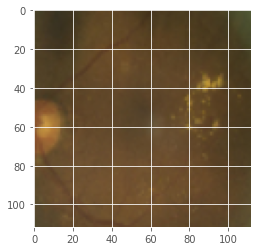

In [6]:
# Check that the images are correct
x,y = training_set.next()
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()

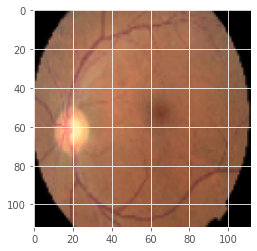

In [8]:
# Check that the images are correct in validation as well.
x,y = validation_set.next()
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [9]:
# Validation Classes
print(validation_set.class_indices)

# Training Classes
print(training_set.class_indices)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


The images made by the generator seem to be working fine with the augments, and are readable / have no artifacts.

###  Convolutional Neural Networks

There are multiple steps in creating a CNN for image classification.

CNN Models have a step-by-step process like the old models we had.

Instead of Instatiante, Fit, and Score, we do:

1 - **Initialize**
    - We set a variable to choose the type of model we want, similar to 'Instantiate'
    
2 - **Convolution**
    - Extracting features from the image, preserving the spatial relationship between pixels as it processes the image a square at a time
    
3 - **Pooling**
    - Reducings the dimensionality of each feature map, but keeping key information
    
4 - **Flatten**
    - Converts the matrix created from convolution, and pooling into a linear array so that it can be input into the Hidden Layer of the Neural Network
    
5 - **Connect**
    - This is connecting our CNN layers into a full web, front to back
    
6 - **Compile**
    - We put the model layers final parts together to complete it, such as which optimizer to use, what kind of classification we are aiming for with our dataset, and what metrics to emphasize
    - We are emphasizing 'Accuracy' because for medical imaging, it is the most important metric; especially when there is a human element regarding health and treatment
    
7 - **Train and Visualize**
    - We visualize the accuracy of the training set, validation set, and the losses to see how we can adjust and improve the model to become more robust
    - We continue this until it reaches a point where we are satisfied with the result

#### Transfer Learning

The layers of a CNN are all there to extract features from the input. The final FC (Fully Connected) layer is what determines which output the model produced, or where it classified the input to. The part of the model that extracts information and learns from different inputs is called the 'Convolution Base', while the final layers are the 'Classifiers'.

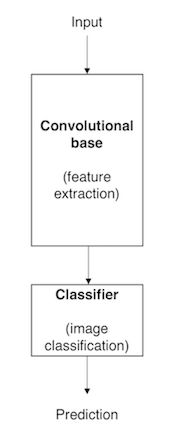

We can use another convolution base to build upon, but a strategy must be employed. I can either train the whole model, some layers of the model, or freeze the entire base and only activate the FC layers to see how this model as a whole works towards my specific problem, but not alter any of the preset weights the model already has.

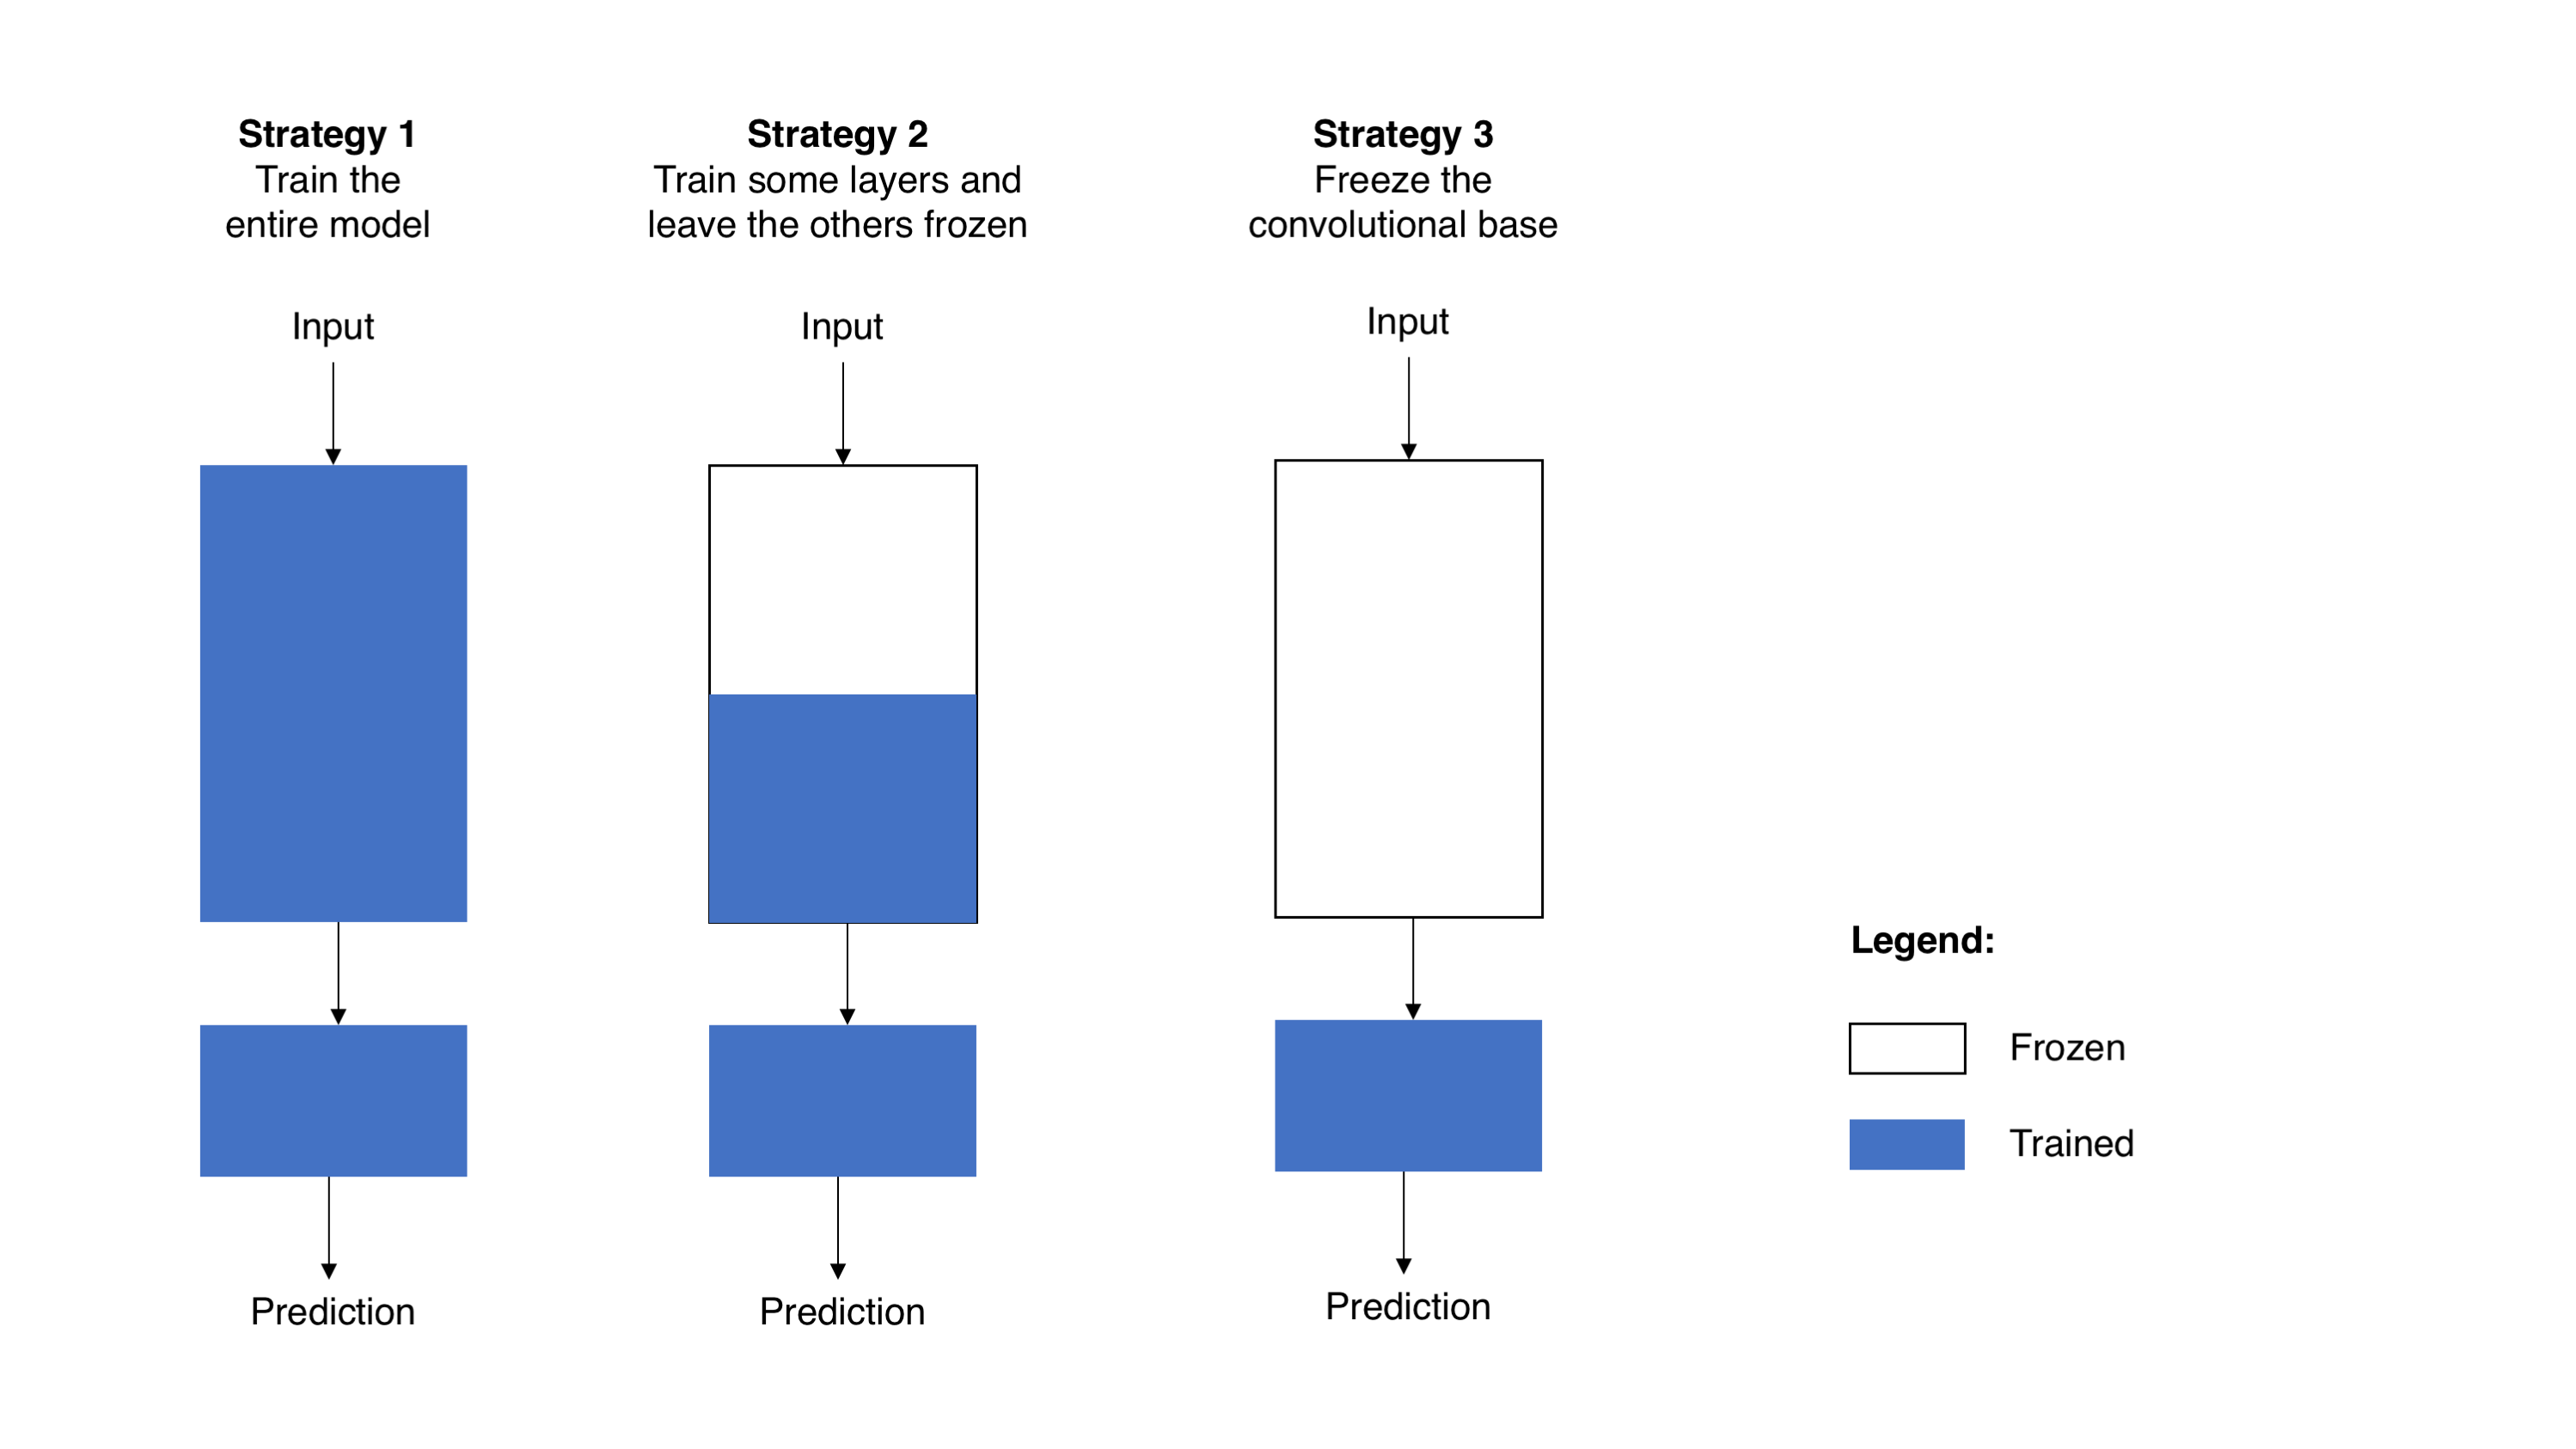

I will be trying the third strategy to test with my dataset.

### Building the Model

#### Preparing Training Parameters

##### Choosing a 'Batch-Size'

A larger batch size will give you a better gradient and will help to prevent jumping around (When visualizing graph accuracy and loss after training.)

You may also want to consider a smaller learning rate, or a learning rate scheduler (or decay) to allow the network to "settle in" as it trains

Too large of a batch_size can produce memory problems, especially if you are using a GPU. Once you exceed the limit, dial it back until it works. This will help you find the max batch-size that your system can work with.
Too large of a batch size can get you stuck in a local minima, so if your training get stuck, I would reduce it some. Imagine here you are over-correcting the jumping-around and it's not jumping around enough to further minimize the loss function.

##### When to reduce 'Epoch'

If your train error is very low, yet your test/validation is very high, then you have over-fit the model with too many epochs.
The best way to find the right balance is to use early-stopping with a validation test set. Here you can specify when to stop training, and save the weights for the network that gives you the best validation loss. I am using an early-stop here to help with overfitting, along with DropOut in the model layers themselves.

##### When to adjust 'Steps-Per-Epoch'

Traditionally, the steps per epoch is calculated as train_length // batch_size, since this will use all of the data points, one batch size worth at a time.

If you are augmenting the data, then you can stretch this a tad (sometimes I multiply that function above by 2 or 3 etc. But, if it's already training for too long, then just stick with the traditional approach.

Batch Size is the number of training examples that get processed at once or in a single batch. Higher number can lead to generalization issues as it can lose on fine detail. As Yann Lecun states: "Minibatch sizes larger than ... They learn quickly, but the wrong thing."

Steps per epoch is usually determined by the number of samples (In this case, 25,000) divided by the batch size (16), which is:

In [10]:
# Steps Per Epoch for Training Data
print(f'Steps Per Epoch: {training_set.n/16}')

# Validation Steps
print(f'Validation Steps: {validation_set.n/16}')

Steps Per Epoch: 195.5
Validation Steps: 48.8125


In [11]:
# Model architecture

# Initialize the CNN model
base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (112,112, 3))

# Freeze the convolution base such that it isn't overwritten by my data
base_model.trainable = False

# Because I removed the 1000 class neuron classifier at the end, I have to replace it with one that is relative to my own
X = base_model.output
X = GlobalAveragePooling2D()(X)
X = Dense(1024, activation = 'relu')(X)

# Final layer with softmax activation
preds = Dense(5, activation = 'softmax')(X) 

# The model must be compiled
model = Model(inputs = base_model.input, outputs = preds)
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
# Check the summary of the model to see all the layers used
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 118, 118, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 56, 56, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 56, 56, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

If Data Augmentation is used, it is in good practice to increase this value a bit more than Total / Batch.

#### Training the Model

In [ ]:
# Set the generator to create a validation set, and the parameters for how it will train.
model.fit_generator(
    generator = training_set,
    steps_per_epoch = 240, # (Total / Batch) + Data Aug
    epochs = 20,
    validation_data = validation_set,
    validation_steps = 60, # (Total / Batch) + Data Aug
    callbacks = [EarlyStopping(patience = 3), ReduceLROnPlateau(patience = 2)])

model.save('Saved Models/resnet50_1.h5')

#### Visualize the Results

In [ ]:
# We should plot the results of the models training
# Set the lists for each part of the models' history and the epochs used so we can plot them
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = np.arange(1,14)

# Make a subplot for 'loss' and one for 'accuracy'
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epoches')
plt.ylabel('Accuracy %')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

Oh my, this model is actually learning quite well. I will continue to train this model.

### Fine-Tuning a CNN Model, v2

I will load in the model again, and train it while monitoring validation accuracy. If this does not improve, it will end the training early.

Shuffled in new training data from the directories as well.
Big dataset, didn't want to load it all in and have my computer suffer more than it needs to.

In [ ]:
# Load in the saved model again.
model = load_model('Saved Models/resnet50_1.h5')

# Continue training...
model.fit_generator(
    generator = training_set,
    steps_per_epoch = 300, # (Total / Batch) + Data Aug
    epochs = 40,
    validation_data = validation_set,
    validation_steps = 70, # (Total / Batch) + Data Aug
    callbacks=[EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True), ReduceLROnPlateau(patience=2)])
model.save('Saved Models/dr_resnet_v2.h5')

In [ ]:
# We should plot the results of the models training
# Set the lists for each part of the models' history and the epochs used so we can plot them
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = np.arange(1,11)

# Make a subplot for 'loss' and one for 'accuracy'
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoches')
plt.ylabel('Accuracy %')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Early stop stopped it. I will remove the early stop and just have it go for a fair bit and see what happens...

Current Validation Accuracy: ~53%
Best Model So Far: dr_resnet_v2

#### Further Training v3

Adding in regularization, and trying again.

In [ ]:
opt = keras.optimizers.Adam(lr=0.00001)

In [ ]:
# Model architecture

# Initialize the CNN model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape = (224,224, 3))

# Freeze the convolution base such that it isn't overwritten by my data
base_model.trainable = False

# Because I removed the 1000 class neuron classifier at the end, I have to replace it with one that is relative to my own
X = base_model.output
X = Flatten()(X)
X = Dense(1024, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(X)
X = Dropout(0.5)(X)

# Final layer with softmax activation
preds = Dense(5,activation='softmax')(X) 

# The model must be compiled
model = Model(inputs = base_model.input, outputs = preds)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Continue training...
model.fit_generator(
    generator = training_set,
    steps_per_epoch = 200, # (Total / Batch) + Data Aug
    epochs = 40,
    validation_data = validation_set,
    validation_steps = 50, # (Total / Batch) + Data Aug
    callbacks=[EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=2)])
model.save('Saved Models/dr_resnet_v3.h5')

Model isn't learning anymore. We need to go... DEEPER.
The loss is decreasing but the accuracy is not.

#### Further Training... v4

I need to make changes to this model to see if I can improve it. 
- I will load in the model that the last training session saved. 
- This model however, is a functionalAPI model, not a Sequential model. It means that I can't make changes to it. 
    - In order to manipulate this model, I instead will create another model that consists only of the changes I wanted to make to my last model.
    - I will set this created model to take in the output of the last model, MINUS the final classifier layer, as it should be the last layer.
    - So the model will end up being like this: Old Model Output[-1 Layer] --> New Model Changes --> Classifier --> Save New Model Architecture

In [ ]:
# Load old model
v3_model = load_model('Saved Models/dr_resnet_v2.h5')

In [ ]:
# Checking to make sure I am bypassing the right layer.
print(f'This is the Dense(5) layer output: {v3_model.layers[-1].output}')
print(f'This is the Dense(1024) layer output: {v3_model.layers[-2].output}')

I want the output of the second last layer, the Dense(1024) layer output to go into the newer model. Not the output of the classifier layer, which is the layers[-1] output.

In [ ]:
# Lets also lower the learning rate...
opt = keras.optimizers.Adam(lr = 0.00001)

In [ ]:
# Make it Sequential to add layers to it; how it is now, it's a functional api model.
tune_v3_model = Sequential()

# Now I can edit my model to make it better...
tune_v3_model.add(Dense(1024,activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
tune_v3_model.add(Dropout(0.5))

# Final layer with softmax activation
tune_v3_model.add(Dense(5,activation='softmax'))

# New edited model, takes in the input that goes into the old model, processes it, then the output from the second last layer (Before the classifier) is sent to the new model. We effectively bypass that layer.
model = Model(inputs = v3_model.input, outputs = tune_v3_model(v3_model.layers[-2].output))

# The model must be compiled
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

In [ ]:
# Continue training...
model.fit_generator(
    generator = training_set,
    steps_per_epoch = 200, # (Total / Batch) + Data Aug
    epochs = 40,
    validation_data = validation_set,
    validation_steps = 50, # (Total / Batch) + Data Aug
    callbacks=[EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=2)])
model.save('Saved Models/dr_resnet_v3.h5')

In [ ]:
# We should plot the results of the models training
# Set the lists for each part of the models' history and the epochs used so we can plot them
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = np.arange(1,18)

# Make a subplot for 'loss' and one for 'accuracy'
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoches')
plt.ylabel('Accuracy %')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Final Tries?

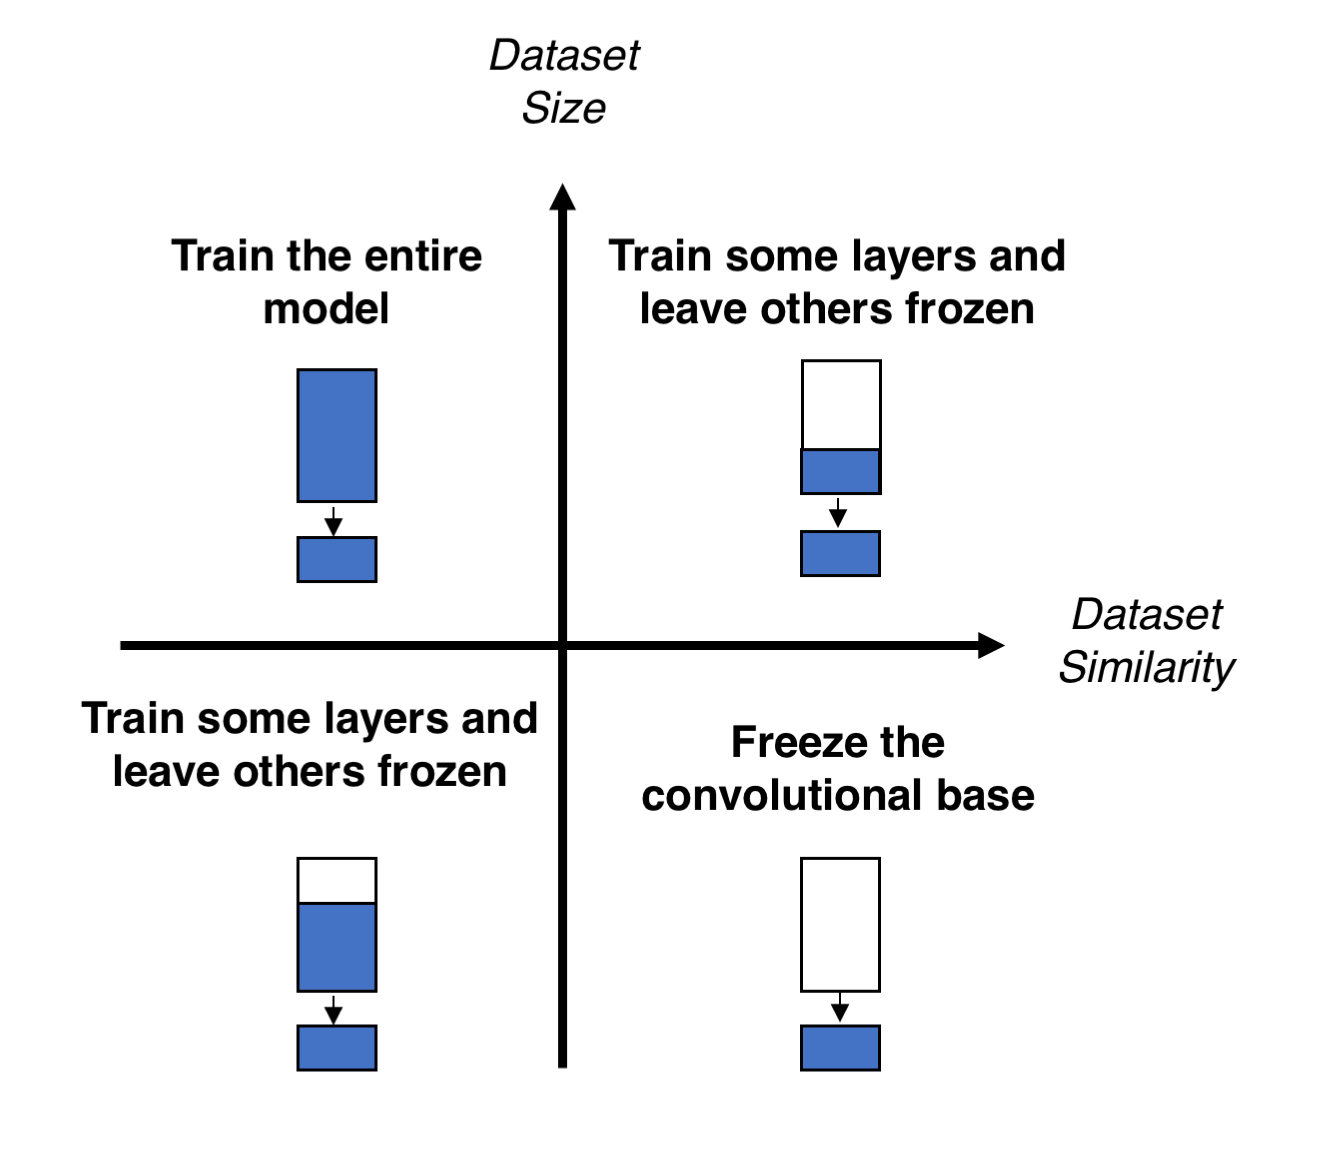

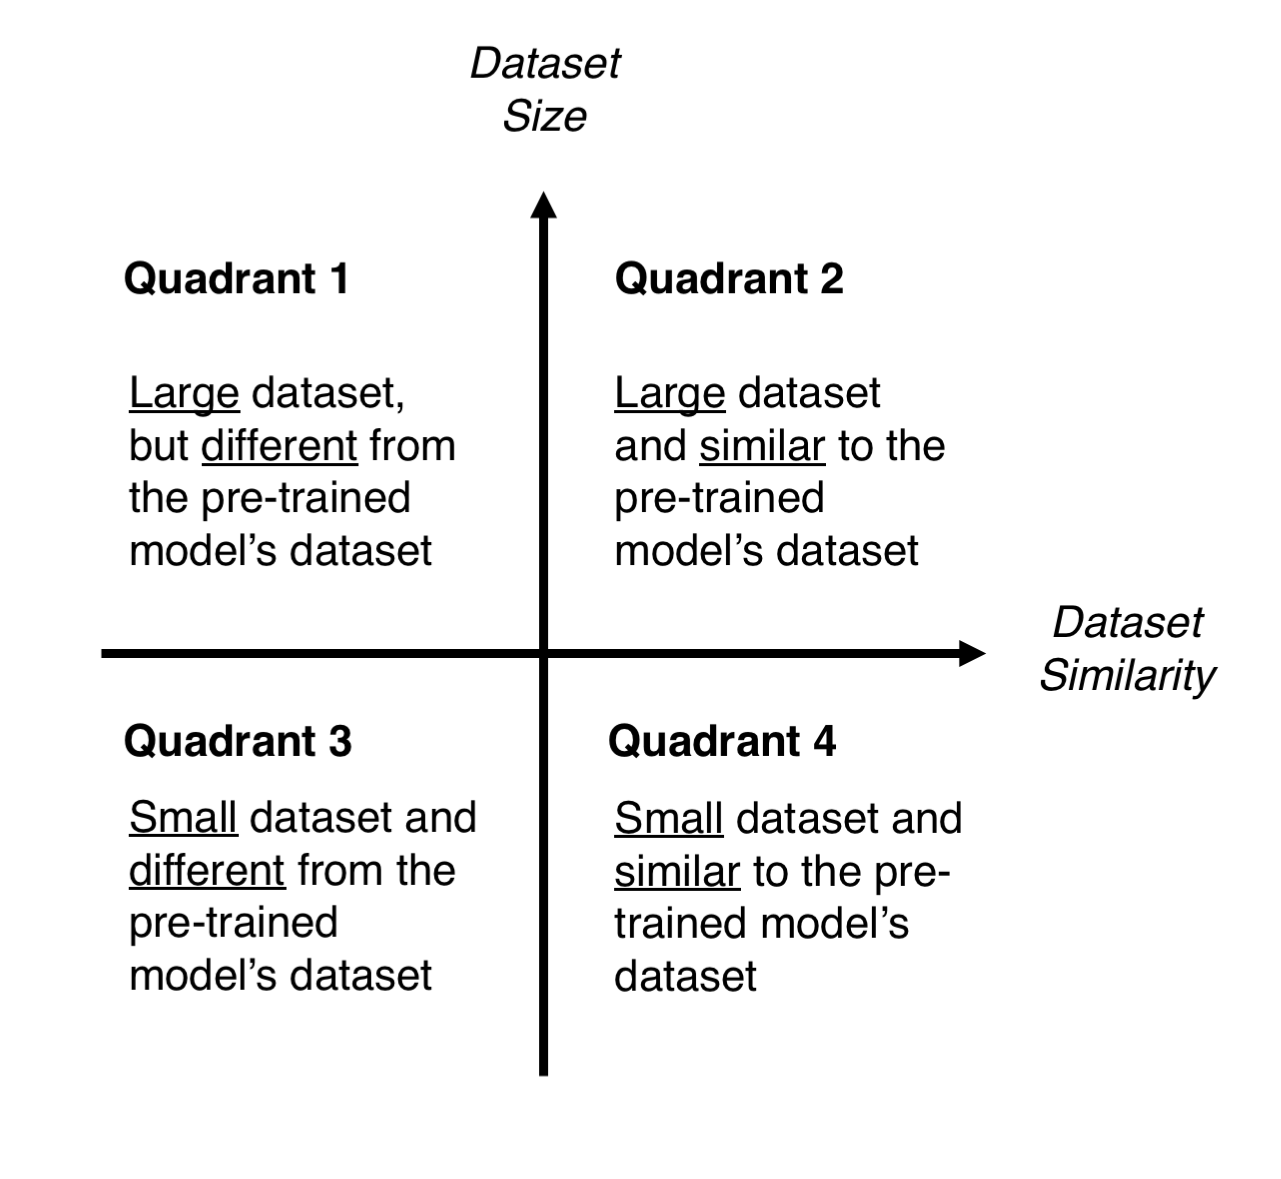

In the end, the freezing and unfreezing may lead to the best results. 
The lack of computational power was really felt in the processing of this dataset as many concessions had to be made which impacted performance and training capability of the model.

TIME IS KING IN CNN!

### What does the model report say...?

The report listed here is inaccurate, as I mistaken loaded another model before printing the one I was to report. The jumbled mess that are my multiple notebooks has made backtracking after demo day much more challenging than anticipated...

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(validation_set, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Absent', 'Mild', 'Moderate', 'Severe', 'Proliferative']
print(classification_report(validation_set.classes, y_pred, target_names=target_names))